In [673]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

def extract_features(data):   
    X = data[['Name','Pclass','Age','Sex','Fare','Ticket','Embarked','SibSp','Parch']].copy()
    X['Title'] = X['Name'].str.extract('([A-Za-z]+)\.').fillna('NA')
    X['Title'] = X['Title'].replace({'Mlle':'Miss','Major':'Mr','Col':'Mr','Sir':'Mr','Don':'Mr',
       'Mme':'Miss','Lady':'Mrs','Jonkheer':'Mr','Capt':'Mr','Countess':'Mrs','Ms':'Miss','Dona':'Mrs'})
    X['Age'] = X.groupby(['Title'])['Age'].transform(lambda g: g.fillna(g.median()))
    X['Fare'] = X['Fare'].fillna(X['Fare'].median())
    X['Fare'] = X.groupby('Ticket')['Fare'].transform(lambda x: x / len(x))
    X['Female'] = X['Sex'].map({'male':0,'female':1})
    X['Family'] = X['SibSp'] + X['Parch']
    X['Embarked'] = X['Embarked'].fillna(X['Embarked'].mode()[0])
    X['Fare'] = pd.cut(X['Fare'], bins=[0,10,20,30,100])
    X['Age'] = pd.cut(X['Age'], bins=[0,9,14,30,100])
    X['Family'] = pd.cut(X['Family'], bins=[0,1,6,20])
    X = pd.get_dummies(X, columns=['Age','Embarked','Fare','Family','Pclass'])
    return X.drop(['Name','Title','Ticket','Sex','SibSp','Parch','Family_(0, 1]','Age_(9, 14]'], axis=1)

def scale_features(X_train, X_test):
    scaler, features = MinMaxScaler(), ['Family']
    X_train[features] = scaler.fit_transform(X_train[features])
    X_test[features] = scaler.transform(X_test[features])
    return X_train, X_test

def align_features(X_train, X_test):
    return X_train.align(X_test, join='outer', axis=1, fill_value=0)

def extract_target(data):
    return data['Survived'].copy()

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('my_test.csv') #@!

y_train = extract_target(train_data)
y_test = extract_target(test_data) #@!
X_train = extract_features(train_data)
X_test = extract_features(test_data)
# X_train, X_test = scale_features(X_train, X_test)
X_train, X_test = align_features(X_train, X_test)

m = LogisticRegression()
# m = KNeighborsClassifier(n_neighbors=8)
# m = RandomForestClassifier(n_estimators=400)
m.fit(X_train, y_train)

# out = pd.DataFrame()
# out['PassengerId'] = test_data.PassengerId
# out['Survived'] = m.predict(X_test)
# out.to_csv('my_submission.csv', index=False)

# cross_val_score(m, X_train, y_train, scoring='accuracy', cv=3).mean()
accuracy_score(y_test, m.predict(X_test)) #@!

0.7989949748743719

In [636]:
from sklearn.model_selection import GridSearchCV
m = LogisticRegression()
grid = {'C':[0.001,0.01,0.1,1,10,100,1000],'penalty':['l1','l2'],'solver': ['liblinear']}
cv = GridSearchCV(m, grid, scoring='accuracy', cv=3)
cv.fit(X_train, y_train)
cv.best_estimator_, cv.best_score_

(LogisticRegression(C=1, penalty='l1', solver='liblinear'), 0.8013468013468014)

In [373]:
# X_train.columns.values[np.argsort(np.abs(m.coef_[0]))].tolist()
# sorted(zip(X_train.columns.values, np.abs(m.coef_[0])), key=lambda x: x[1], reverse=True)

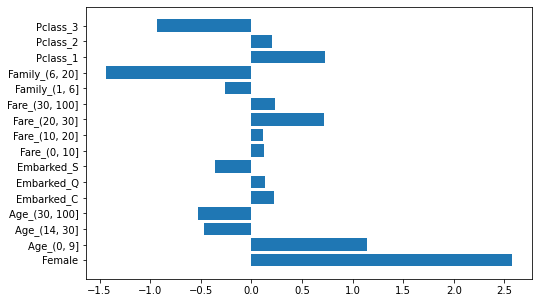

In [674]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.barh(X_train.columns.values, m.coef_[0]);

In [818]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('my_test.csv') #@!
train_len = len(train_data)

df = pd.concat([train_data, test_data])
df['Title'] = df['Name'].str.extract('([A-Za-z]+)\.').fillna('NA')
df['Last_Name'] = df['Name'].str.split(",").str.get(0)
df['Age'] = df.groupby(['Title'])['Age'].transform(lambda g: g.fillna(g.median()))
df['Fare'] = df['Fare'].fillna(df['Fare'].median())
df['Fare'] = df.groupby('Ticket')['Fare'].transform(lambda x: x / len(x))
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
df['Ticket'] = df.groupby('Ticket')['Ticket'].transform(lambda x: '< 3' if len(x) < 3 else x)
df = df.drop(['PassengerId','Name','Title','Last_Name','Cabin','SibSp','Parch'], axis=1)

df['Fare'] = pd.cut(df['Fare'], bins=[0,10,20,30,100])
df['Age'] = pd.cut(df['Age'], bins=[0,8,14,31,100])
df = pd.get_dummies(df, columns=['Pclass','Sex','Age','Embarked','Fare','Ticket'])

y_train = df[:train_len]['Survived']
y_test = df[train_len:]['Survived'] #@!
X_train = df[:train_len].drop(['Survived'], axis=1)
X_test = df[train_len:].drop(['Survived'], axis=1)

m = LogisticRegression()
# m = KNeighborsClassifier(n_neighbors=3, weights='distance')
# m = RandomForestClassifier()
m.fit(X_train, y_train)

out = pd.DataFrame()
out['PassengerId'] = test_data.PassengerId
out['Survived'] = m.predict(X_test)
out.to_csv('my_submission.csv', index=False)

# cross_val_score(m, X_train, y_train, scoring='accuracy', cv=3).mean()
accuracy_score(y_test, m.predict(X_test)) #@!

0.7989949748743719

In [826]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('my_test.csv') #@!
train_len = len(train_data)

df = pd.concat([train_data, test_data])
df['Title'] = df['Name'].str.extract('([A-Za-z]+)\.').fillna('NA')
df['Last_Name'] = df['Name'].str.split(",").str.get(0)
df['Age'] = df.groupby(['Title'])['Age'].transform(lambda g: g.fillna(g.median()))
df['Fare'] = df['Fare'].fillna(df['Fare'].median())
df['Fare'] = df.groupby('Ticket')['Fare'].transform(lambda x: x / len(x))
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
# df['Ticket'] = df.groupby('Ticket')['Ticket'].transform(lambda x: '< 3' if len(x) < 3 else x)
df = df.drop(['PassengerId','Name','Title','Last_Name','Cabin','SibSp','Parch'], axis=1)

df['Fare'] = pd.cut(df['Fare'], bins=[0,10,20,30,100])
df['Age'] = pd.cut(df['Age'], bins=[0,8,15,30,100]) #[0,7.90,14.45,31.28,120]
# df = pd.get_dummies(df, columns=['Pclass','Sex','Age','Embarked','Fare','Ticket'])
# df['Ticket'].unique()